# Test trained model(s)

In [2]:
######################################
#Script to test and log trained model#
#Maintainer: Christopher Chan        #
#Version: 0.3.3                      #
#Date: 2022-04-26                    #
######################################

import os
import sys
import torch
import random
import re
import tqdm
from dataloader import BuildingDataset
import numpy as np
import torchvision.models as models
import segmentation_models_pytorch as smp
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from Networks import Five_UNet, Four_UNet
from torchvision import transforms
from PIL import Image
from scipy import ndimage
%matplotlib inline

device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

print(f"Training on device {device}.")

data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/")
Four_UNet = Four_UNet()

Training on device cpu.


In [3]:
TestIMG_ls = []
TestLBL_ls = []

for root, dirs, filename in os.walk(os.path.join(data_path, "Test_15cm", "IMG")):
    for i in filename:
        #if i.startswith("KBY15_IMG"):
            TestIMG_ls.append(root + "/" + i)

for i in TestIMG_ls:
    
    i = re.sub("IMG", "LBL", i, count = 2)
    TestLBL_ls.append(i)

Test = BuildingDataset(png_dir = TestIMG_ls,
                       lbl_dir = TestLBL_ls)

assert len(Test.png_dir) == len(Test.lbl_dir)

print("Concatenated TESTING images: {0} and labels pair: {0} :".format(len(Test.png_dir)))
for x, y in zip(Test.png_dir, Test.lbl_dir):
    print(f"Image: {x}", f"Label: {y}")


Concatenated TESTING images: 435 and labels pair: 435 :
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZKN15_IMG_6669-3249.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZKN15_LBL_6669-3249.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_28215-22059.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_28215-22059.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/DZK15_IMG_3420-5814.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/DZK15_LBL_3420-5814.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_8037-16416.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_8037-16416.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_29241-22914.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_29241-22914.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_29925-23256.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_

<class 'torch.Tensor'>


Text(0.5, 1.0, 'LBL')

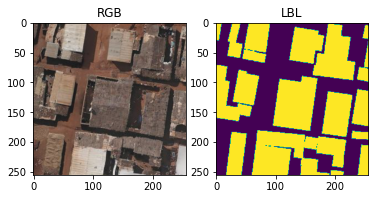

In [4]:
# plot a sample
test = BuildingDataset(TestIMG_ls, TestLBL_ls, transform = None)
test_pair = random.choice(test)

print(type(test_pair[0]))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(test_pair[0].cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(test_pair[1].cpu().numpy().transpose(1, 2, 0))
ax.set_title('LBL')

### Vanilla Four layer U-Net Baseline

In [5]:
weights_4UNet = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "18242:3909_256oc_Four-Unet_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_280360.pth"))
weights_4UNet = torch.load(weights_4UNet, map_location = device)
Four_UNet.load_state_dict(weights_4UNet["Model:"])
Four_UNet.to(device = device)

print(sum(p.numel() for p in Four_UNet.parameters() if p.requires_grad == True))

7763041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 3.696351541293552e-06, Maximum: 0.005070783197879791, Mean: 0.0021203537471592426, St dev: 0.0016341852024197578
True Positive = 35759, True Negative = 24266 False Negative = 804, False Positive = 4707
Precision = 0.8836801052093506, Recall = 0.9780105352401733, Specificity = 0.8375384211540222 Overall Accuracy = 0.9159088134765625, Intersection-over-Union = 0.8664647340774536, Dice-Score = 0.9284554719924927


Text(0.5, 1.0, 'Binary Segmentation')

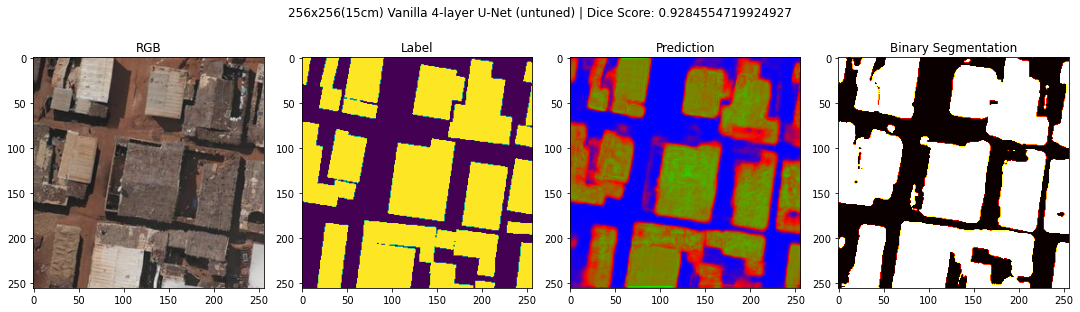

In [6]:
Four_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = Four_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)
   
    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) Vanilla 4-layer U-Net (untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### Qubvel OpenCities EB1-UNet

In [7]:
qubvelEB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
qubvel_weights = torch.load(qubvel_weights, map_location = device)
qubvelEB1_UNet.load_state_dict(qubvel_weights["state_dict"])
qubvelEB1_UNet.to(device = device)

print(sum(p.numel() for p in qubvelEB1_UNet.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 7.637657207903236e-18, Maximum: 1.0, Mean: 0.2494189590215683, St dev: 0.42901983857154846
True Positive = 16883, True Negative = 27599 False Negative = 19680, False Positive = 1374
Precision = 0.9247412085533142, Recall = 0.46175095438957214, Specificity = 0.9525765180587769 Overall Accuracy = 0.678741455078125, Intersection-over-Union = 0.44502729177474976, Dice-Score = 0.6159431338310242


Text(0.5, 1.0, 'Binary Segmentation')

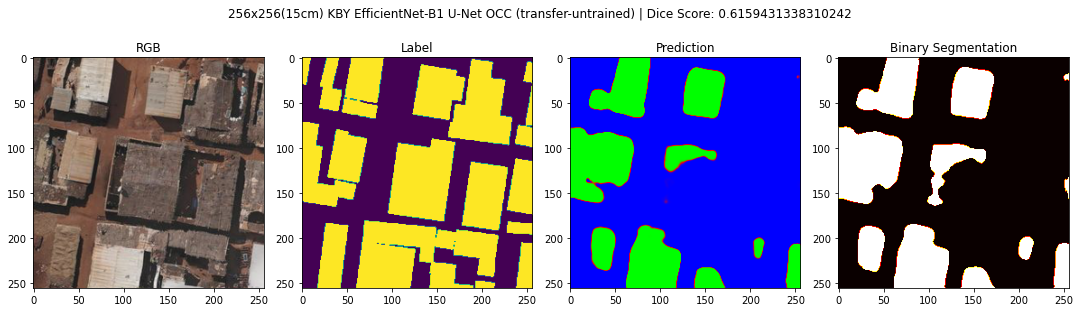

In [8]:
qubvelEB1_UNet.eval()

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = qubvelEB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet-B1 U-Net OCC (transfer-untrained) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet Vanilla (No ImageNet) Baseline

In [9]:
EB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

EB1_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "18242:3909_256oc_EB1-Unet-NoIMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_160450.pth"))
EB1_weights = torch.load(EB1_weights, map_location = device)
EB1_UNet.load_state_dict(EB1_weights["Model:"])
EB1_UNet.to(device = device)

print(sum(p.numel() for p in EB1_UNet.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 7.004599865467753e-06, Maximum: 0.006386242341250181, Mean: 0.0020166896283626556, St dev: 0.0015255854232236743
True Positive = 35079, True Negative = 23618 False Negative = 1484, False Positive = 5355
Precision = 0.867561936378479, Recall = 0.9594125151634216, Specificity = 0.8151727318763733 Overall Accuracy = 0.8956451416015625, Intersection-over-Union = 0.8368481397628784, Dice-Score = 0.9111783504486084


Text(0.5, 1.0, 'Binary Segmentation')

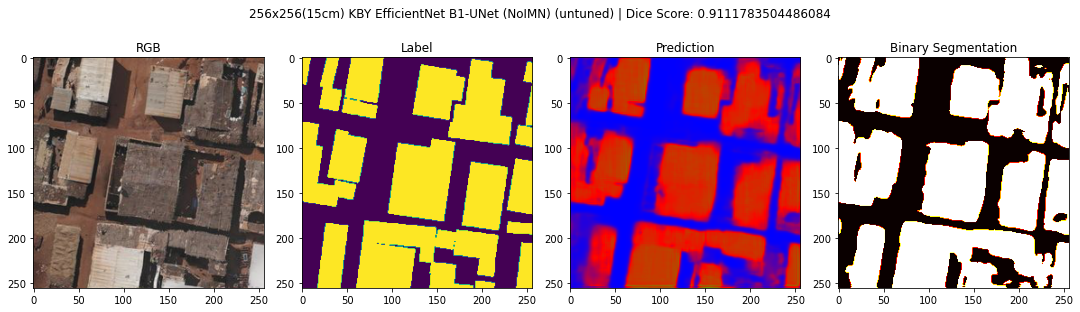

In [10]:
EB1_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))


# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet B1-UNet (NoIMN) (untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet ImageNet (trained-untuned) Baseline

In [11]:
EB1_UNet_IMN = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

IMN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "18242:3909_256oc_EB1-Unet-IMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_223260.pth"))
IMN_weights = torch.load(IMN_weights, map_location = device)
EB1_UNet_IMN.load_state_dict(IMN_weights["Model:"])
EB1_UNet_IMN.to(device = device)

print(sum(p.numel() for p in EB1_UNet_IMN.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 5.070301085652318e-06, Maximum: 0.018198465928435326, Mean: 0.002131359651684761, St dev: 0.0016050118720158935
True Positive = 35693, True Negative = 23663 False Negative = 870, False Positive = 5310
Precision = 0.8704972863197327, Recall = 0.9762054681777954, Specificity = 0.8167259097099304 Overall Accuracy = 0.90570068359375, Intersection-over-Union = 0.8524108529090881, Dice-Score = 0.9203258752822876


Text(0.5, 1.0, 'Binary Segmentation')

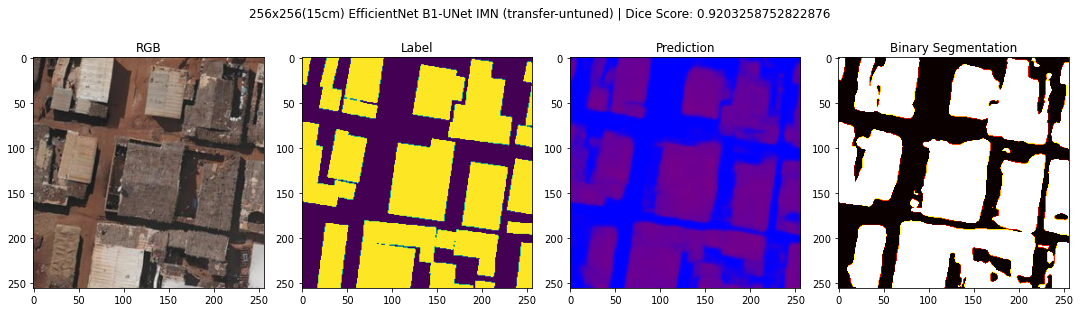

In [12]:
EB1_UNet_IMN.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_IMN(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B1-UNet IMN (transfer-untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet OCC (transfer-trained) Baseline

In [13]:
EB1_UNet_OCCtrans = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

OCCtrans_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "18242:3909_256oc_EB1-Unet-qubvel_lr1e-3_wd1e-5_b16_ep500_BCE_RLRonPlateau(min1e-8)_iter_548820.pth"))
OCCtrans_weights = torch.load(OCCtrans_weights, map_location = device)
EB1_UNet_OCCtrans.load_state_dict(OCCtrans_weights["Model:"])
EB1_UNet_OCCtrans.to(device = device)

print(sum(p.numel() for p in EB1_UNet_OCCtrans.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 1.1747351891244762e-06, Maximum: 0.007773537654429674, Mean: 0.0020952271297574043, St dev: 0.001587801263667643
True Positive = 35074, True Negative = 22944 False Negative = 1489, False Positive = 6029
Precision = 0.8533197045326233, Recall = 0.9592757821083069, Specificity = 0.7919096946716309 Overall Accuracy = 0.885284423828125, Intersection-over-Union = 0.8234879970550537, Dice-Score = 0.9032009243965149


Text(0.5, 1.0, 'Binary Segmentation')

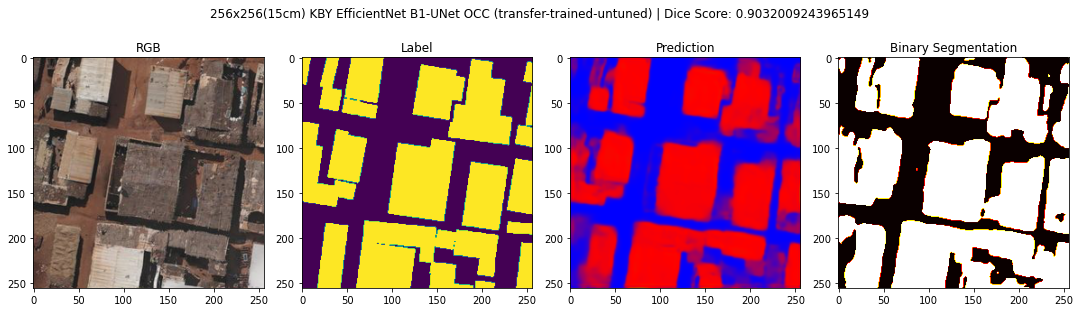

In [14]:
EB1_UNet_OCCtrans.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_OCCtrans(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet B1-UNet OCC (transfer-trained-untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B2-UNet (NoIMN) Baseline

In [15]:
EB2_UNet_NoIMN = smp.Unet(encoder_name = 'efficientnet-b2', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

EB2_NoIMN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "18242:3909_256oc_EB2-Unet-NoIMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_286070.pth"))
EB2_NoIMN_weights = torch.load(EB2_NoIMN_weights, map_location = device)
EB2_UNet_NoIMN.load_state_dict(EB2_NoIMN_weights["Model:"])
EB2_UNet_NoIMN.to(device = device)

print(sum(p.numel() for p in EB2_UNet_NoIMN.parameters() if p.requires_grad == True))

8211283


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 7.656278285139706e-06, Maximum: 0.00661174301058054, Mean: 0.0021071764640510082, St dev: 0.0015821738634258509
True Positive = 35463, True Negative = 24000 False Negative = 1100, False Positive = 4973
Precision = 0.8770155310630798, Recall = 0.9699149131774902, Specificity = 0.828357458114624 Overall Accuracy = 0.9073333740234375, Intersection-over-Union = 0.8537895083427429, Dice-Score = 0.9211288094520569


Text(0.5, 1.0, 'Binary Segmentation')

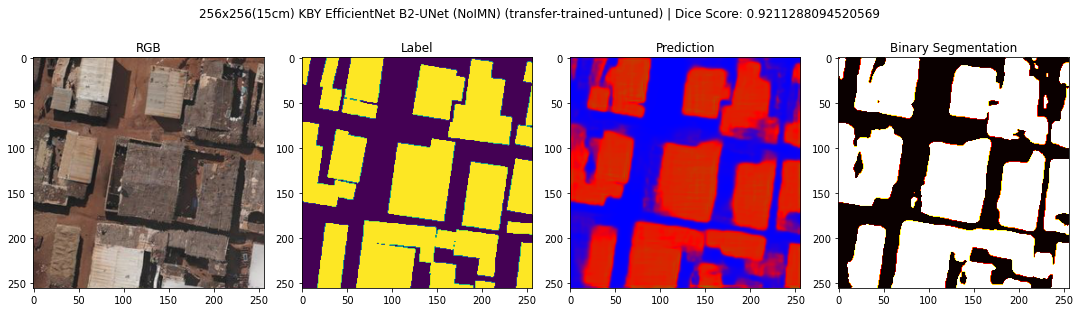

In [16]:
EB2_UNet_NoIMN.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB2_UNet_NoIMN(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet B2-UNet (NoIMN) (transfer-trained-untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B2-UNet (IMN) Baseline

In [17]:
EB2_UNet_IMN = smp.Unet(encoder_name = 'efficientnet-b2', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

EB2_IMN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmALL", "18242:3909_256oc_EB2-Unet-IMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_263230.pth"))
EB2_IMN_weights = torch.load(EB2_IMN_weights, map_location = device)
EB2_UNet_IMN.load_state_dict(EB2_IMN_weights["Model:"])
EB2_UNet_IMN.to(device = device)

print(sum(p.numel() for p in EB2_UNet_IMN.parameters() if p.requires_grad == True))

8211283


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 1.489701844548108e-06, Maximum: 0.011255609802901745, Mean: 0.0020995987579226494, St dev: 0.0015839317347854376
True Positive = 35145, True Negative = 22847 False Negative = 1418, False Positive = 6126
Precision = 0.8515664935112, Recall = 0.9612176418304443, Specificity = 0.7885617613792419 Overall Accuracy = 0.8848876953125, Intersection-over-Union = 0.8232799768447876, Dice-Score = 0.9030757546424866


Text(0.5, 1.0, 'Binary Segmentation')

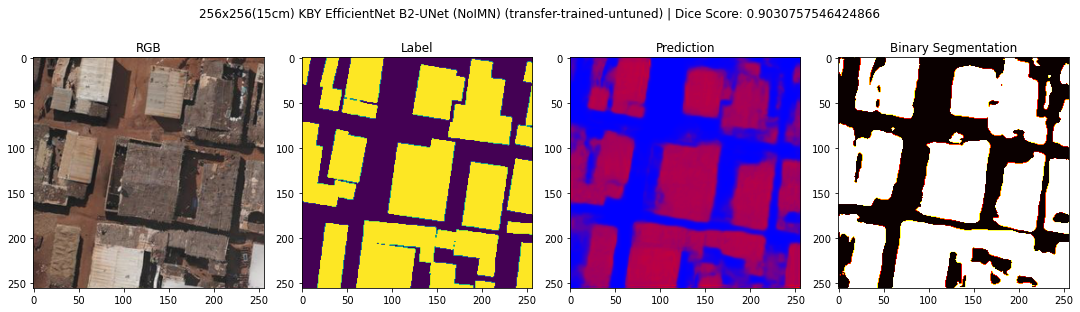

In [18]:
EB2_UNet_IMN.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB2_UNet_sIMN(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet B2-UNet (NoIMN) (transfer-trained-untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')